In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

#### Вспомогательные функции

In [2]:
def func(x, y, t):
    """
    f(x,t) в исходном уравнении
    """
    return 2 * np.sin(x + y) + (2 * t) / (t ** 2 + 1)


def mu(p, t):
    """
    Граничные условия
    """
    return np.sin(p) + np.log(t ** 2 + 1)
    
    
def phi(x, y):
    """
    Начальные условия
    """
    return np.sin(x + y)


def init(N, T, h, delta):
    """
    Задание начальных и граничных условий
    """
    x = np.array([i * h for i in range(N + 1)])
    y = np.array([i * h for i in range(N + 1)])
    t = np.array([j * delta for j in range(T + 1)])
    U = np.zeros(shape=(N + 1, N + 1, T + 1))
    for j in range(N + 1):
        for i in range(N + 1):
            U[i, j, 0] = phi(x[i], y[j])
    for i in range(N + 1):
        U[0, i, :] = mu(y[i], t.T)
        U[-1, i, :] = mu(y[i], t.T)
        U[i, 0, :] = mu(x[i], t.T)
        U[i, -1, :] = mu(x[i], t.T)
    return x, y, t, U


def real(x, y, t):
    """
    Форма точного решения
    """
    return np.sin(x + y) + np.log(t ** 2 + 1)


def exact(h, delta):
    """
    Точное решение
    """
    N = int(2 * np.pi / h) 
    T = int(10 / delta) 
    x, y, t, _ = init(N, T, h, delta)
    U_real = np.zeros(shape=(N + 1, N + 1, T + 1))
    for k in range(T + 1):
        for j in range(N + 1):
            for i in range(N + 1):
                U_real[i, j, k] = real(x[i], y[j], t[k])
    return x, y, t, U_real


#### Представление результата

In [3]:
def error_max(U, h, delta):
    """
    Вычисление ошибки
    """
    x, y, t, U_real = exact(h, delta)
    return np.max(np.abs(U - U_real))


def error_shape(U, h, delta):
    """
    Нахождение формы ошибки
    """
    x, y, t, U_real = exact(h, delta)
    return np.abs(U - U_real)


def plot_t(x, y, t, U):    
    """
    Построение графика U(x, y) при t 
    """
    title = "U(x, y, t=" + str(t) + ")"
    fig = plt.figure()
    ax = fig.gca(projection="3d")
    X, Y = np.meshgrid(x, y)
    Z = U[:, :, t]
    ax.plot_surface(X, Y, Z, cmap="viridis", rstride=1, cstride=1, linewidth=0)    
    ax.view_init(30, 220);
    plt.suptitle(title)
    plt.show()
    
def plot_x(y, t, x, U):
    """
    Построение графика U(y, t) при x 
    """
    title = "U(y, t, x=" + str(x) + ")"
    fig = plt.figure()
    ax = fig.gca(projection="3d")
    X, Y = np.meshgrid(y, t)
    Z = U[x, :, :].T
    ax.plot_surface(X, Y, Z, cmap="viridis", rstride=1, cstride=1, linewidth=0)    
    ax.view_init(30, 220);
    plt.suptitle(title)
    plt.show() 
    
    
def result(schema):
    """
    Сравнение результатов для разных 
    разбиений по x и t
    """
    _errors = []
    _steps = []
    _deltas = []
    steps = [np.pi / 5, np.pi / 10, np.pi / 20]
    deltas = [0.25, 0.10, 0.05]
    
    x, y, t, U = schema(steps[0], deltas[0])
    _, _, _, U_real = exact(steps[0], deltas[0])
    
    print("Exact:")
    plot_t(x, y, -1, U_real)
    plot_x(y, t, -1, U_real)
    print("Alt_dim:")
    plot_t(x, y, -1, U)
    plot_x(y, t, -1, U)
    print("Error:")
    plot_t(x, y, -1, error_shape(U, steps[0], deltas[0]))
    plot_x(y, t, -1, error_shape(U, steps[0], deltas[0]))
    
    for h in steps:
        for delta in deltas:
            x, y, t, U = schema(h, delta)
            err = error_max(U, h, delta)
            _errors.append(err)
            _steps.append(h)
            _deltas.append(delta)

    df = pd.DataFrame(data={
        "step": _steps, 
        "delta": _deltas,
        "error": _errors
    })
    
    print("Max errors:")
    return df

#### Реализация метода прогонки

In [4]:
def thomas_solver(a, b, c, d):
    """
    Метод прогонки
    """
    nf = len(d) 
    ac, bc, cc, dc = map(np.array, (a, b, c, d))
    for it in range(1, nf):
        mc = ac[it - 1] / bc[it - 1]
        bc[it] = bc[it] - mc * cc[it - 1] 
        dc[it] = dc[it] - mc * dc[it - 1] 
    xc = bc
    xc[-1] = dc[-1] / bc[-1]

    for il in range(nf-2, -1, -1):
        xc[il] = (dc[il] - cc[il] * xc[il + 1]) / bc[il]
    return xc


### Метод переменных направлений 

In [5]:
def alt_dim(h, delta):
    """
    Метод переменных направлений
    """
    # Учтем промежуточные шаги по t
    delta = delta / 2

    N = int(2 * np.pi / h) 
    T = int(10 / delta) 
    gamma = delta / (h ** 2)
    x, y, t, U = init(N, T, h, delta)

    A = np.ones(shape=(N,)) * (- 1) * gamma
    B = np.ones(shape=(N + 1,)) * (1 + 2 * gamma)
    C = np.ones(shape=(N,)) * (- 1) * gamma
    D = np.zeros(shape=(N + 1, N + 1))
       
    for j in range(T):
        
        if j % 2 != 0:
            # Прогонка по x
            for k in range(1, N):
                D[:, k] = (
                    gamma * U[:, k - 1, j] + (1 - 2 * gamma) * U[:, k, j] + gamma * U[:, k + 1, j] + 
                    delta * func(x, y[k], t[j + 1])
                )
            for i in range(1, N):
                U[:, i, j + 1] = thomas_solver(A, B, C, D[i]) 
         
        else:
            # Прогонка по y
            for k in range(1, N):
                D[k] = (
                    gamma * U[k - 1, :, j] + (1 - 2 * gamma) * U[k, :, j] + gamma * U[k + 1, :, j] + 
                    delta * func(x[k], y, t[j + 1])
                )
            for i in range(1, N):
                U[:, i, j + 1] = thomas_solver(A, B, C, D[i])   
                
        U[:, 0, j + 1] = mu(x, t[j + 1])
        U[:, -1, j + 1] = mu(x, t[j + 1])
        U[0, :, j + 1] = mu(y, t[j + 1])
        U[-1, :, j + 1] = mu(y, t[j + 1])

    return x, y, t[::2], U[:, :, ::2]

Exact:


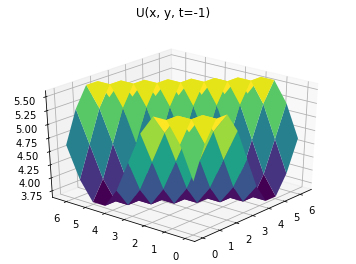

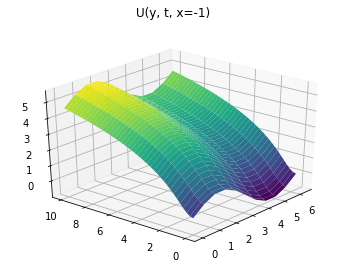

Alt_dim:


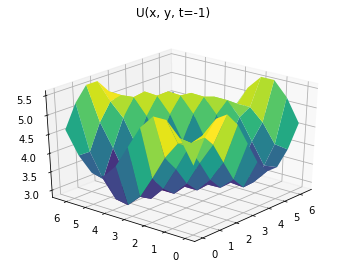

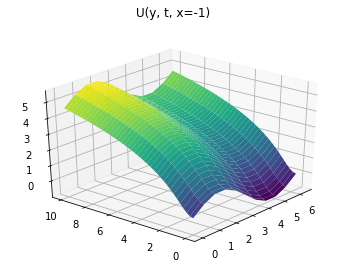

Error:


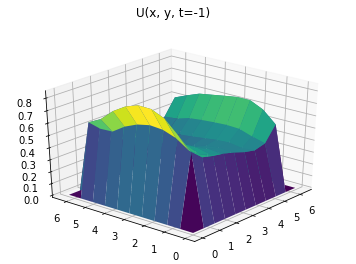

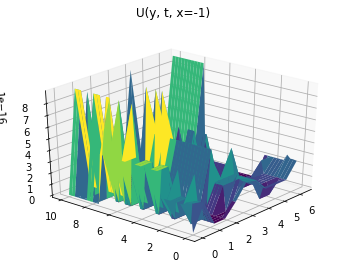

Max errors:


In [6]:
df = result(alt_dim)

In [7]:
df

,delta,error,step
0,0.25,8.400294e-01,0.628319
1,0.10,4.271191e-01,0.628319
2,0.05,2.432074e-01,0.628319
3,0.25,3.652864e+13,0.314159
4,0.10,1.399103e+00,0.314159
5,0.05,8.702111e-01,0.314159
6,0.25,1.181476e+45,0.157080
7,0.10,1.967054e+69,0.157080
8,0.05,1.318426e+48,0.157080
